In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Модель энергонезависимого мемристора

$$
\frac{dx(t)}{dt} = a V^S(t) f(x(t), V(t))
$$

Здесь $f(x, V)$ - оконная функция Biolek:

$$
f(x, V) = 
\begin{cases}
1 - (1-x)^{2p}, V \leq -V_{th} \\
1 - x^{2p}, V \geq V_{th} \\
0, |V| \leq V_{th}
\end{cases}
$$

$$
p = round \left( \frac{b}{|V| + c} \right)
$$

Задача решается численно относительно x. Запишем разностную схему для данной задачи:

$$
\frac{x_{i+1} - x_i}{\Delta t} = a V^S(t_i) f(x_i, V(t_i))
$$

С учетом начальных условий получаем:

$$
x_{i+1} = a V^S(t_i) f(x_i, V(t_i)) \Delta t + x_i, x_0 = 0
$$

In [3]:
class signhal:

    amplitude: float
    n_periods: float
    shift: float

    def sine_wave(time_array, amplitude = 1.0, n_periods = 1.0, shift = 0):
        scale = (2 * np.pi) / (time_array[-1] - time_array[0])
        return amplitude * np.sin(scale * (time_array - shift) * n_periods)
    
    def triangle(time_array, amplitude = 1.0):
        quater_period = (time_array[-1] - time_array[0]) / 4
        voltage = []
        for i in range(len(time_array)):
            if time_array[i] <= quater_period:
                voltage.append(amplitude / quater_period * (time_array[i]))
            elif (time_array[i] > quater_period) and (time_array[i] < 3 * quater_period):
                voltage.append(- amplitude / quater_period * (time_array[i] - quater_period) + amplitude)
            else:
                voltage.append(amplitude / quater_period * (time_array[i] - 3 * quater_period) - amplitude)
        return np.array(voltage)
    
    def bipolar_rectangle(time_array, duty_cycle = 0.25, positive_amplitude = 1.0, negative_amplitude = -1.0):
        half_period = (time_array[-1] - time_array[0]) / 2
        voltage = []
        for i in range(len(time_array)):
            if time_array[i] <= half_period * (1 - 2 *  duty_cycle):
                voltage.append(0)
            elif (time_array[i] > half_period * (1 - 2 *  duty_cycle)) and (time_array[i] < half_period):
                voltage.append(positive_amplitude)
            elif (time_array[i] >= half_period) and (time_array[i] < 2 * half_period * (1 - duty_cycle)):
                voltage.append(0)
            else:
                voltage.append(negative_amplitude)
        voltage[-1] = 0
        return np.array(voltage)

    

In [4]:
V_th = 1.3
a = 1
b= 15
c = 2
s = 5
n = 5
beta = 7.069 * 10 ** (-5)
xi = 1.946 * 10 ** (-4)
alpha_m = 1.8
gamma = 0.15

def p_calc(V):
    return int(b/(np.abs(V) + c))

def f_calc(x, V):
    if V <= -V_th:
        return 1 - (1 - x) ** (p_calc(V))
    elif V >= V_th:
        return 1 - x ** ( p_calc(V))
    else:
        return 0
    
def voltage(time_array, amplitude = 2.0, n_periods = 1.0, shift = 0):
    return signhal.sine_wave(time_array, amplitude= amplitude, n_periods= n_periods, shift=shift)
    
def x_calc(time_array, Voltage):
    delta_t = time_array[1] - time_array[0]
    x = [0]
    for i in range(1, len(time_array)):
        x.append(a * Voltage[i-1] ** s * f_calc(x[i-1], Voltage[i-1]) * delta_t + x[i-1])
    return np.array(x)

def current_calc(time_array, Voltage):
    x = x_calc(time_array, Voltage)
    return x ** n * beta * np.sinh(alpha_m * Voltage) + xi * (np.exp(gamma * Voltage) - 1)


Text(0.5, 493.54575163398704, 't, s')

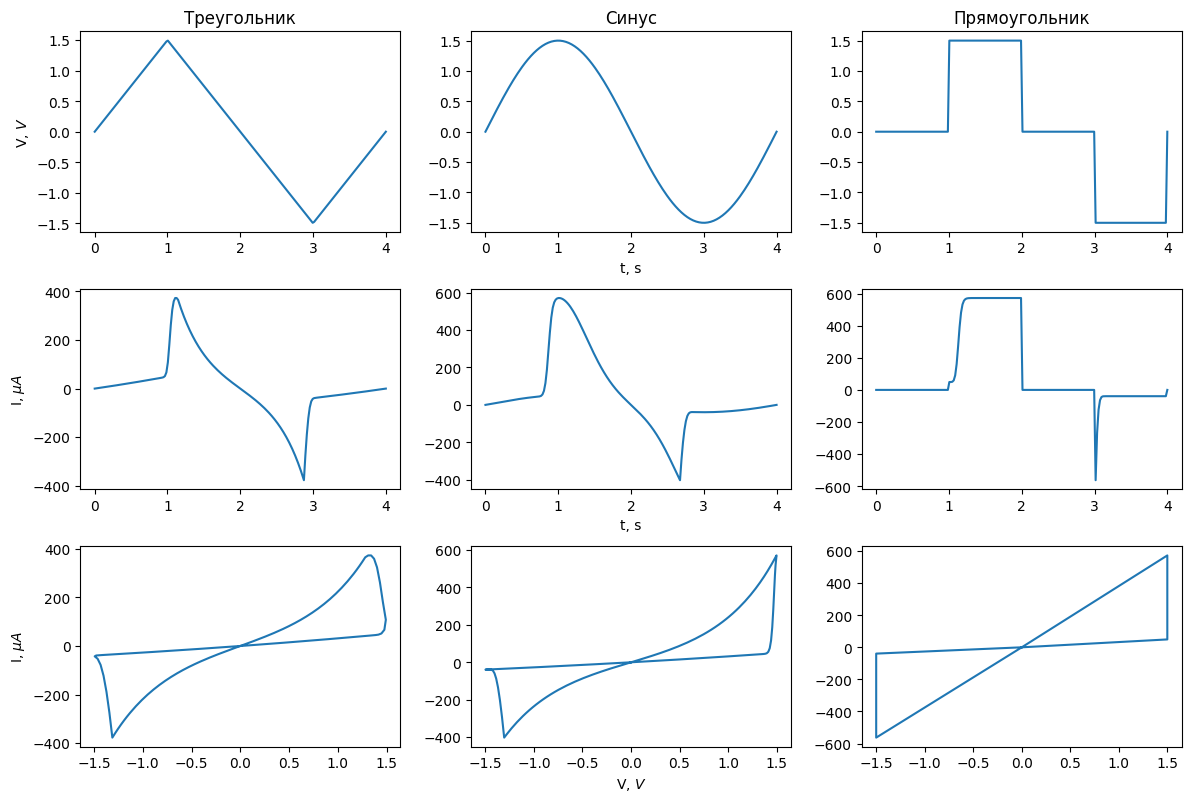

In [6]:
t = np.linspace(0,4,200)

fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = [12, 8])
fig.tight_layout(pad=2)
#plt.suptitle(r'Зависимость $I$ и $V$ от формы поданного напряжения')

V = signhal.triangle(t, 1.5)
I = current_calc(t,V)
ax[0,0].plot(t,V)
ax[1,0].plot(t,I* 1000000)
ax[2,0].plot(V, (I)* 1000000)


V = signhal.sine_wave(t, 1.5)
I = current_calc(t,V)
ax[0,1].plot(t,V)
ax[1,1].plot(t,I * 1000000)
ax[2,1].plot(V, (I)* 1000000)

V = signhal.bipolar_rectangle(t, duty_cycle= 0.25, positive_amplitude=1.5, negative_amplitude= -1.5)
I = current_calc(t,V)
ax[0,2].plot(t,V)
ax[1,2].plot(t,I * 1000000)
ax[2,2].plot(V, (I)* 1000000)

ax[0,0].set_title('Треугольник')
ax[0,1].set_title('Синус')
ax[0,2].set_title('Прямоугольник')

ax[2,0].set_ylabel(r'I, $\mu A$')
ax[1,0].set_ylabel(r'I, $\mu A$')
ax[0,0].set_ylabel(r'V, $V$')

ax[2,1].set_xlabel(r'V, $V$')
ax[1,1].set_xlabel(r't, s')
ax[0,1].set_xlabel(r't, s')

#plt.savefig('wave_form_dependence.png', dpi = 300, bbox_inches = 'tight')